# Cahn-Hilliard 3D
Adapted from fenics [Cahn-Hilliard 2D example](https://fenicsproject.org/docs/dolfin/latest/python/demos/cahn-hilliard/demo_cahn-hilliard.py.html).

Goal: Solve the PDE from paper: [_Solving Allen-Cahn and Cahn-Hilliard Equations using the Adaptive Physics Informed Neural Networks_](https://arxiv.org/abs/2007.04542) given as
$$u_t = \Delta(\gamma_2(u^3-u)-\gamma_1\Delta u)$$

In [14]:
from dolfin import *
from time import perf_counter
import scipy.io
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

output = "solutions/cahn-hilliard-3d/"

In [2]:
## parameters
#####################################

(nx, ny, nz) = (20, 20, 20)     # mesh points
theta        = 0.5              # combo of current solution with previous
dt           = 10e-3            # time step
(x0, xf)     = (0.0, 1.0)       # x-boundaries
(y0, yf)     = (0.0, 1.0)       # y-boundaries
(z0, zf)     = (0.0, 1.0)       # z-boundaries

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [3]:
# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

In [4]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left, bottom, and front faces are the target domains
    def inside(self, x, on_boundary):
        return (near(x[0], x0) or near(x[1], y0) or near(x[2], z0)) and on_boundary

    # Map:
    #  + right face to left face
    #  + top face to bottom face
    #  + back face to front face
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)
        y[1] = x[1] - (yf - y0)
        y[2] = x[2] - (zf - z0)

In [5]:
# return random uniform distribution over [-scale/2, scale/2]
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        np.random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
        self.scale = 1.0
    def eval(self, values, x):
        values[0] = self.scale * np.random.rand() - self.scale/2
        values[1] = 0.0
    def value_shape(self):
        return(2,)

In [6]:
# formulate problem
#####################################

# create periodic boundary condition
pbc = PeriodicBoundary()

# setup mesh
mesh = BoxMesh(Point(x0, y0, z0), Point(xf, yf, zf), nx, ny, nz)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1, constrained_domain=pbc)

# define trial and test functions
du = TrialFunction(ME)
(v, q) = TestFunction(ME)

# define functions
u = Function(ME)
u0 = Function(ME)

# split mixed functions
(dq, dmu) = split(du)
(c,  mu)  = split(u)
(c0, mu0) = split(u0)

# initial conditions
u_init = InitialConditions(degree=0)
u.interpolate(u_init)
u0.interpolate(u_init)

# mu_(n+theta)
mu_mid = (1.0-theta)*mu0 + theta*mu
gamma1 = Constant(1.0e-6)
gamma2 = Constant(1.0/100)

F0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
F1 = mu*v*dx - gamma2*(c**3 - c)*v*dx - gamma1*dot(grad(c), grad(v))*dx
F = F0 + F1

# compute Jacobian
J = derivative(F, u, du)

In [7]:
# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(J, F)
solver = NewtonSolver()

file = File(output + 'data/ch3.pvd', "compressed")

In [8]:
# map mesh vertices to solution DOFs
#####################################

dof_coordinates = ME.tabulate_dof_coordinates()
c_dofs = ME.sub(0).dofmap().dofs()
dofs = np.squeeze(dof_coordinates[c_dofs])

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100

Took 2019.11 seconds.


<IPython.core.display.Javascript object>


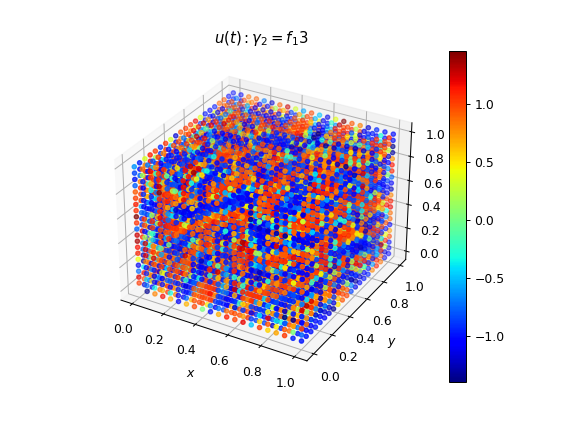

In [9]:
# time stepping
#####################################

(t, T) = (0.0, 1.0)
(n, N) = (0, int(round(T/dt, 0)))

sol = {}
sol['x'] = dofs
sol['t'] = np.zeros((N,1))
sol['u'] = np.zeros((len(sol['x']), len(sol['t'])))

t0 = perf_counter()
while n < N:
    
    # compute current solution
    solver.solve(problem, u.vector())
    
    # save output
    sol['t'][n] = t
    sol['u'][:,n] = u.vector()[c_dofs]
    file << (u.split()[0], t)
    
    # update previous solution
    u0.vector()[:] = u.vector()

    # print progress
    if n % round(N/10,0) == 0:
        print(f"{n} / {N}")
        
    # increment time
    t += dt
    n += 1
    
tf = perf_counter()
print(f"\nTook {tf-t0:.2f} seconds.")

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
h = ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], s=12, c=u.vector()[c_dofs], cmap='jet')
plt.title(f"$u(t):\gamma_2={gamma2}$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
fig.colorbar(h, ax=ax)
plt.show()

In [10]:
def snapshot(i):
    plt.cla()
    ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], s=30, c=sol['u'][:,i], cmap='jet')
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    ax.set_xlabel('$x$',fontsize='x-large')
    ax.set_ylabel("$y$",fontsize='x-large')
    ax.set_zlabel("$z$",fontsize='x-large')
    plt.title(fr'Cahn-Hilliard')
    ax.view_init(30, 30)
    plt.draw()

<IPython.core.display.Javascript object>


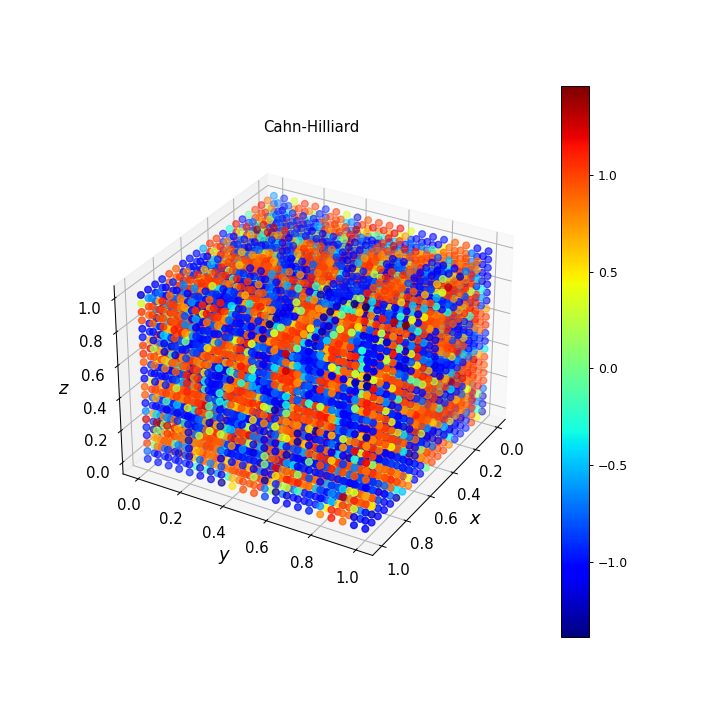

In [11]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
h = ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], s=30, c=sol['u'][:,N-1], cmap='jet')
fig.colorbar(h, ax=ax)
snapshot(1)
snapshot(N-1)

<IPython.core.display.Javascript object>


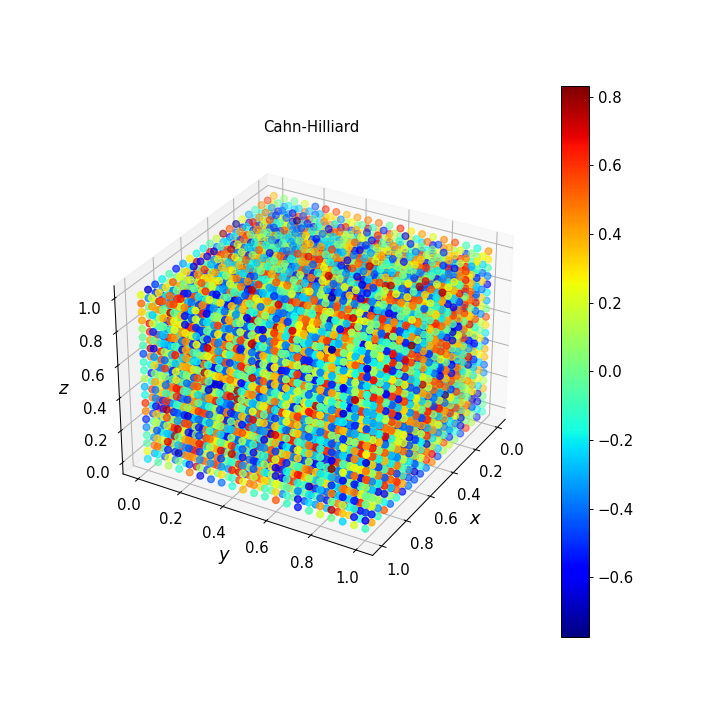

In [12]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
h = ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], c=sol['u'][:,1], cmap='jet')
fig.colorbar(h, ax=ax)

anim = animation.FuncAnimation(fig,snapshot,frames=N)
anim.save(output + 'cahn-hilliard-3d.mp4',fps=N/10)